# GoBi 2024/25 - Spatial2

**Supervisors:** Heinig, Träuble\
**Students:** Bui, Hansen, Hummel, Stein

In [1]:
import anndata as ad
import scanpy as sc
#import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import cell2location as c2l
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
from dotenv import load_dotenv
load_dotenv()

True

#### Data import

In [2]:
adata_scatlas = ad.read_h5ad(os.environ.get('PATH_TO_SCATLAS'))
adata_visium = ad.read_h5ad(os.environ.get('PATH_TO_VISIUM'))

In [3]:
adata_scatlas.var_names = adata_scatlas.var["original_gene_names"]

In [4]:
# Remove existing deconvolution results from the Visium data
keys_to_remove = ['means_cell_abundance_w_sf', 'stds_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf']
for key in keys_to_remove:
    if key in adata_visium.obsm:
        del adata_visium.obsm[key]

if 'mod' in adata_visium.uns:
    del adata_visium.uns['mod']

cell_type_columns = [
    'B cells', 'Conventional DC', 'EC, Adjacent (Alsaigh)', 'EC, Artery', 'EC, DKK2 (Atherosclerosis)', 
    'EC, Lymphatic', 'EC, Vasa vasorum', 'Fibroblast', 'Fibroblast (COL9A3+)', 'Macrophages (CD1C+)', 
    'Macrophages (LYVE1+)', 'Macrophages (M4)', 'Macrophages (SPP1+)', 'Macrophages, Developing', 'Macrophages, Foamy', 
    'Macrophages, Inflammatory', 'Macrophages, Proliferating', 'Macrophages, Unknown', 'Mast cells', 'Myofibroblast', 
    'Natural Killer cells', 'Natural Killer cells (Atherosclerosis)', 'Neuron', 'Neutrophils', 'Pericytes', 'Plasma cells', 
    'Plasmacytoid DC', 'T cells (CD8+)', 'T cells, (Mixed CD4/CD8)', 'T cells, CD4+ memmory', 'T cells, CD8+ activated', 
    'T cells, High mitochrondrial reads', 'T cells, Proliferating', 'T cells, regulatory', 'Th1 helper cells (CD4+)', 
    'VSMC', 'VSMC, Osteoblastic'
]

for col in cell_type_columns:
    if col in adata_visium.obs:
        del adata_visium.obs[col]

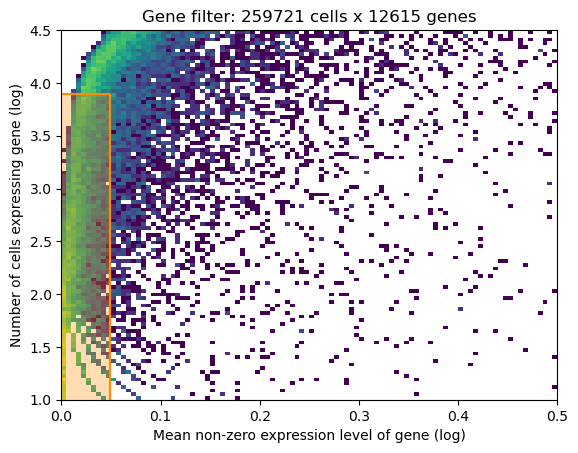

In [5]:
from cell2location.utils.filtering import filter_genes
adata_ref = adata_scatlas.copy()
adata_ref.X = adata_ref.raw.X
selected = filter_genes(adata_ref, cell_count_cutoff=1, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()

## 3. Import Model

In [6]:
# Load the model (node: it is the path to the folder containing model.pt, so do not include model.pt in your path)
model2wo = c2l.models.RegressionModel.load(os.environ.get('PATH_TO_ATLAS_MODEL2WO'), adata_ref)
adata_ref = model2wo.export_posterior(
    adata_ref, use_quantiles=True,
    add_to_varm=["q05","q50", "q95"],
    sample_kwargs={'batch_size': 2500}
)
# For the QC plot afterwards
adata_ref = model2wo.export_posterior(adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500})

INFO     File /home/b/buit/atlas_model/model.pt already downloaded                                                 


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/77 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Sampling local variables, batch:   0%|          | 0/104 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

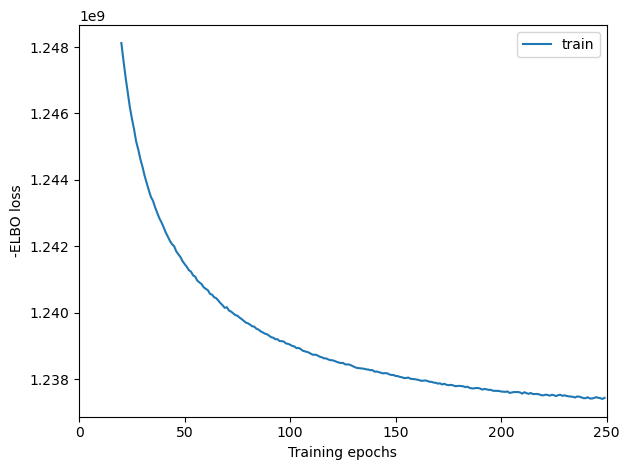

In [7]:
model2wo.plot_history(20)

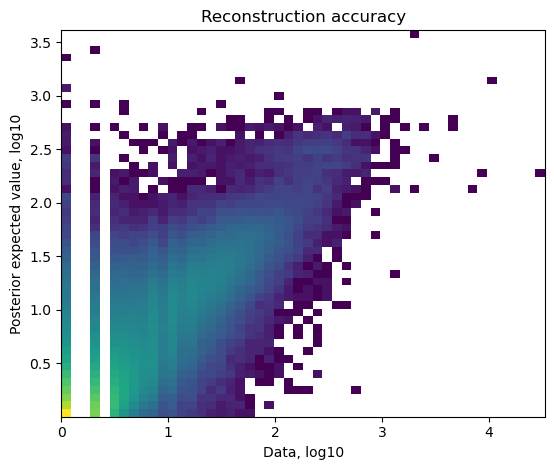

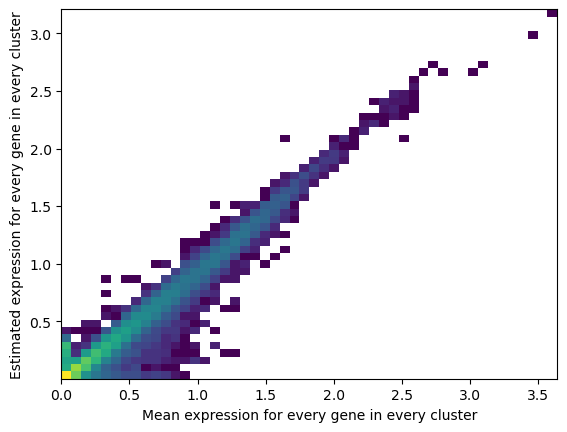

In [8]:
# Examine QC plot
model2wo.plot_QC()

In [9]:
# Extracting reference cell types signatures as a pd.DataFrame
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver

,B cell,CD4 T cell,CD8 T cell,Conventional dendritic cell 1,Conventional dendritic cell 2,EndoMT EC,Fibroblast,Fibromyocyte,HMOX1+ Macrophage,Inflammatory Macrophage,...,NK cell,Neutrophil,Other Macrophage,PLIN2+/TREM1+ Macrophage,Plasma cell,Plasmacytoid dendritic cell,Pro-Angiogenic EC,Smooth Muscle Cell,TREM2+/Foamy Macrophage,Undefined
original_gene_names,,,,,,,,,,,,,,,,,,,,,
TSPAN6,0.000220,0.000820,0.000042,0.056395,0.000581,0.423245,0.116659,0.079052,0.002523,0.001107,...,0.000219,0.000380,0.000207,0.001241,0.004210,0.000860,0.128563,0.044282,0.001180,0.007048
TNMD,0.000088,0.000016,0.000022,0.005299,0.000252,0.000848,0.000121,0.000097,0.000239,0.000373,...,0.000125,0.000299,0.000042,0.001029,0.000558,0.001250,0.001671,0.000059,0.000157,0.207483
DPM1,0.059752,0.084325,0.073393,0.293564,0.282343,0.221257,0.236633,0.202523,0.157624,0.184447,...,0.073862,0.003838,0.146555,0.290262,0.138477,0.234828,0.182419,0.144412,0.334280,0.183639
SCYL3,0.010627,0.018026,0.011655,0.020106,0.022108,0.029231,0.027904,0.024121,0.029539,0.024709,...,0.015574,0.002644,0.027030,0.023063,0.013343,0.080571,0.030008,0.016025,0.034922,0.020265
FGR,0.008531,0.000467,0.017696,0.646155,0.907617,0.099168,0.005463,0.001247,0.278525,0.763094,...,0.208358,0.213186,0.194727,1.015498,0.009521,0.013901,0.057557,0.000505,0.890845,0.151802
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AC253572.2,0.003220,0.000062,0.000052,0.032195,0.330925,0.000349,0.000158,0.000112,0.063899,0.232088,...,0.000253,0.000329,0.226758,0.279833,0.023529,0.327143,0.000153,0.000063,0.056918,0.042863
AC092803.4,0.000094,0.000036,0.000024,0.001646,0.014851,0.000172,0.000151,0.000255,0.010683,0.022336,...,0.000135,0.001077,0.013689,0.016784,0.000628,0.000692,0.000119,0.000101,0.005286,0.005007
AC093849.4,0.000157,0.000040,0.000037,0.001961,0.003974,0.002081,0.000270,0.000159,0.011369,0.010835,...,0.000247,0.000301,0.017918,0.004424,0.000598,0.000975,0.001460,0.000077,0.017498,0.005448


## 4. Cell type mapping

In [10]:
adata_visium.obs['sample']

spot_id
FW104302_AAACAAGTATCTCCCA-1    FW104302
FW104302_AAACACCAATAACTGC-1    FW104302
FW104302_AAACAGAGCGACTCCT-1    FW104302
FW104302_AAACAGCTTTCAGAAG-1    FW104302
FW104302_AAACAGGGTCTATATT-1    FW104302
                                 ...   
FW106022_TTGTCGTTCAGTTACC-1    FW106022
FW106022_TTGTGAGGCATGACGC-1    FW106022
FW106022_TTGTGGCCCTGACAGT-1    FW106022
FW106022_TTGTTCTAGATACGCT-1    FW106022
FW106022_TTGTTTCCATACAACT-1    FW106022
Name: sample, Length: 16593, dtype: category
Categories (12, object): ['FW104302', 'FW104306', 'FW104860', 'FW106005_v2', ..., 'FW106014', 'FW106016', 'FW106018', 'FW106022']

In [11]:
def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

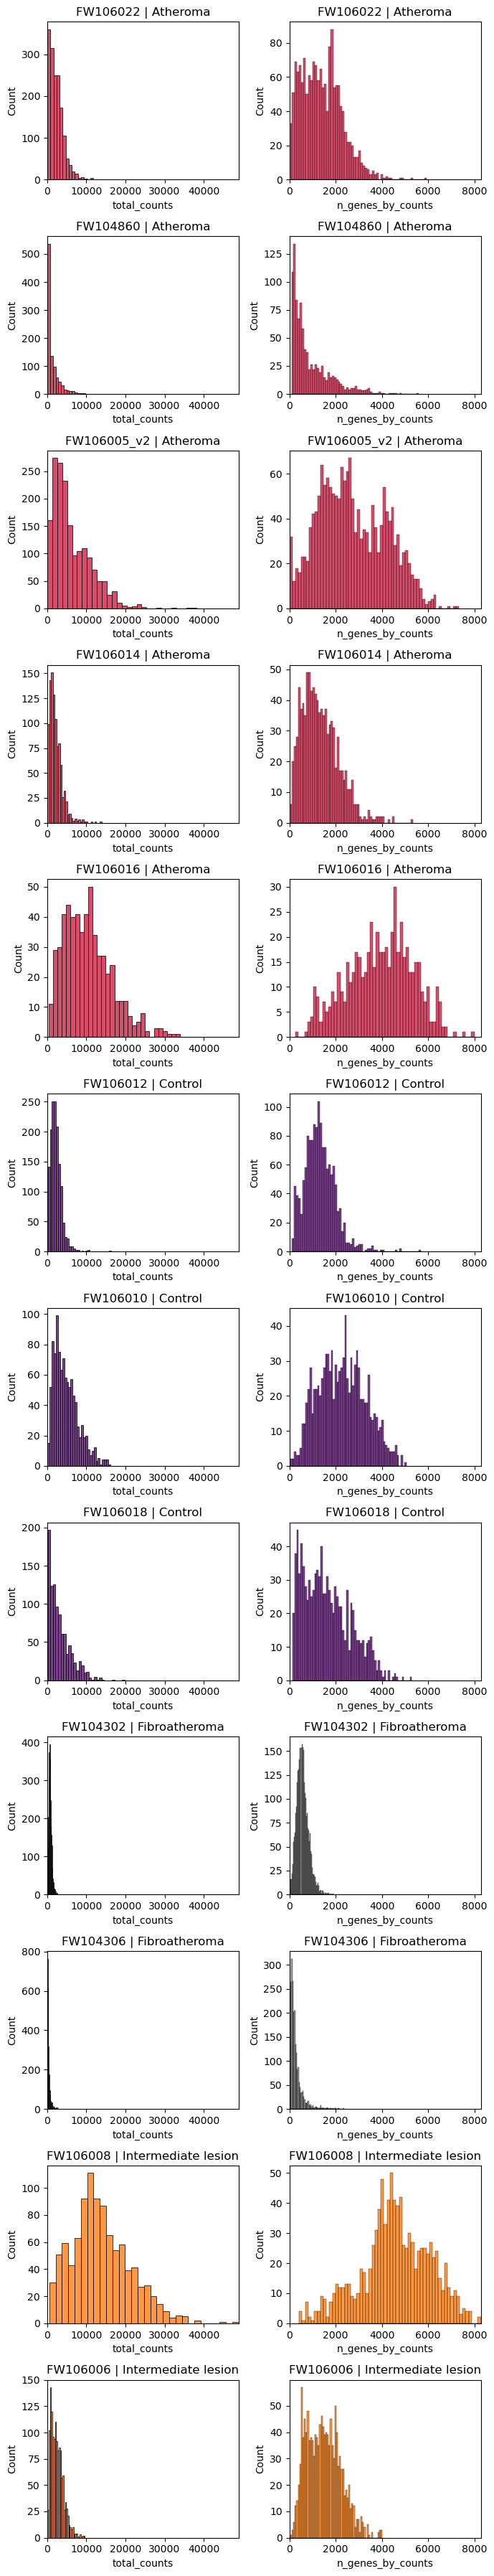

In [12]:
# Do manual sample mapping like in the paper
Sample_to_Disease = dict(
    FW104302="Fibroatheroma",
    FW104306="Fibroatheroma",
    FW104860="Atheroma",
    FW106005_v2="Atheroma",
    FW106006="Intermediate lesion",
    FW106008="Intermediate lesion",
    FW106010="Control",
    FW106012="Control",
    FW106014="Atheroma",
    FW106016="Atheroma",
    FW106018="Control",
    FW106022="Atheroma")
adata_visium.obs['Disease'] = (
    adata_visium.obs['sample'].map(Sample_to_Disease)
)
# Sort samples by disease group
sorted_samples = adata_visium.obs.sort_values(by='Disease')['sample'].unique()

# PLOT QC FOR EACH SAMPLE

fig, axs = plt.subplots(len(sorted_samples), 2, figsize=(7, len(sorted_samples)*3))

# Define color palette for disease categories
disease_palette = {'Control': '#52006A', 'Intermediate lesion': '#FF7600', 
                   'Atheroma': '#CD113B', 'Fibroatheroma': '#808080'}

for i, s in enumerate(sorted_samples):
    slide = select_slide(adata_visium, s)
    sample_value = adata_visium.obs.loc[adata_visium.obs['sample'] == s, 'sample'].unique()[0]
    disease_value = adata_visium.obs.loc[adata_visium.obs['sample'] == s, 'Disease'].unique()[0]
    header = f'{sample_value} | {disease_value}'

    # Get color for the disease category
    disease_color = disease_palette.get(disease_value, 'gray')

    # Plot the distribution of total_counts
    sns.histplot(slide.obs['total_counts'], kde=False, ax=axs[i, 0], color=disease_color, bins=30)
    axs[i, 0].set_xlim(0, adata_visium.obs['total_counts'].max())
    axs[i, 0].set_xlabel('total_counts')
    axs[i, 0].set_title(header)

    # Plot the distribution of n_genes_by_counts
    sns.histplot(slide.obs['n_genes_by_counts'], kde=False, ax=axs[i, 1], color=disease_color, bins=60)
    axs[i, 1].set_xlim(0, adata_visium.obs['n_genes_by_counts'].max())
    axs[i, 1].set_xlabel('n_genes_by_counts')
    axs[i, 1].set_title(header)

plt.tight_layout()
plt.show()


In [13]:
adata_visium.obs.keys()

Index(['in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac',
       '_indices', '_scvi_batch', '_scvi_labels', 'leiden', 'region_cluster',
       'Disease'],
      dtype='object')

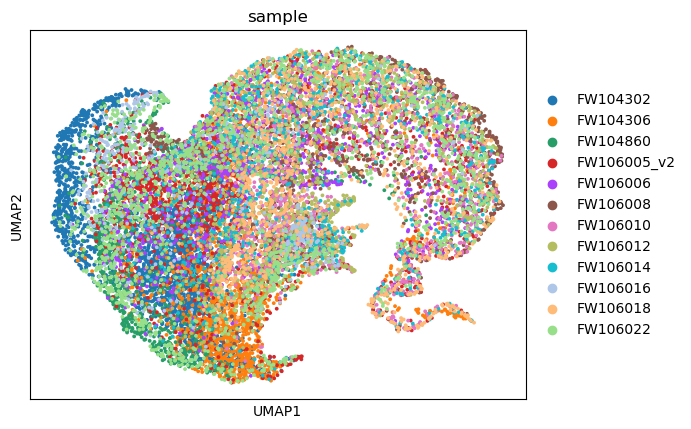

In [14]:
sc.pl.umap(adata_visium, color=['sample'], size=30,
               color_map = 'RdPu', ncols = 1, legend_fontsize=10)

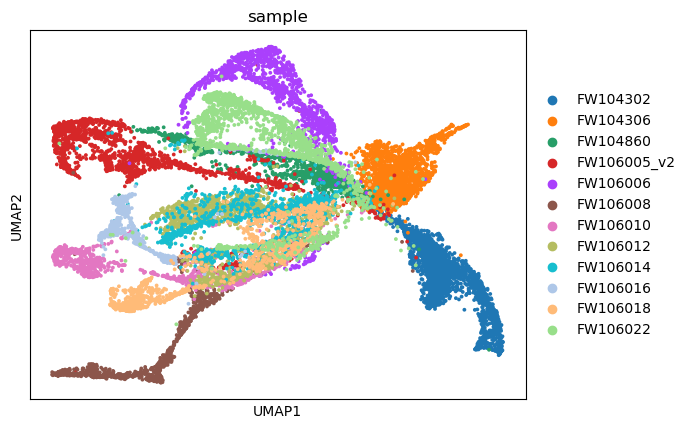

In [15]:
# Plot UMAP with log-transformed data

# Log-transform (log(data + 1))
adata_vis_plt = adata_visium.copy()
sc.pp.log1p(adata_vis_plt)

# Find highly variable genes within each sample
adata_vis_plt.var['highly_variable'] = False
for s in adata_vis_plt.obs['sample'].unique():
    adata_vis_plt_1 = adata_vis_plt[adata_vis_plt.obs['sample'] == s, :]
    sc.pp.highly_variable_genes(adata_vis_plt_1, n_top_genes=3000)  
    hvg_list = list(adata_vis_plt_1.var_names[adata_vis_plt_1.var['highly_variable']])
    adata_vis_plt.var.loc[hvg_list, 'highly_variable'] = True

# Scale the data
sc.pp.scale(adata_vis_plt, max_value=10)

# PCA, KNN construction, UMAP
sc.tl.pca(adata_vis_plt, svd_solver='arpack', n_comps=40, mask_var='highly_variable')  
sc.pp.neighbors(adata_vis_plt, n_neighbors=25, n_pcs=40, metric='cosine')
sc.tl.umap(adata_vis_plt, min_dist=0.3, spread=1)

# Plot UMAP
sc.pl.umap(adata_vis_plt, color=['sample'], size=30, color_map='RdPu', ncols=1, legend_fontsize=10)

In [16]:
adata_visium.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts-FW104302,mean_counts-FW104302,log1p_mean_counts-FW104302,pct_dropout_by_counts-FW104302,total_counts-FW104302,log1p_total_counts-FW104302,...,log1p_mean_counts-FW106018,pct_dropout_by_counts-FW106018,total_counts-FW106018,log1p_total_counts-FW106018,n_cells_by_counts-FW106022,mean_counts-FW106022,log1p_mean_counts-FW106022,pct_dropout_by_counts-FW106022,total_counts-FW106022,log1p_total_counts-FW106022
A1CF,ENSG00000148584,Gene Expression,GRCh38,False,0,0.000000,0.000000,100.000000,0.0,0.000000,...,0.000000,100.000000,0.0,0.000000,1,0.000627,0.000627,99.937304,1.0,0.693147
A2M,ENSG00000175899,Gene Expression,GRCh38,False,739,0.340926,0.293360,73.282719,943.0,6.850126,...,1.470714,25.967413,3292.0,8.099554,1256,3.513480,1.507068,21.253918,5604.0,8.631414
AADAC,ENSG00000114771,Gene Expression,GRCh38,False,4,0.001808,0.001806,99.855387,5.0,1.791759,...,0.000000,100.000000,0.0,0.000000,2,0.001254,0.001253,99.874608,2.0,1.098612
AADACL2,ENSG00000197953,Gene Expression,GRCh38,False,2,0.000723,0.000723,99.927693,2.0,1.098612,...,0.000000,100.000000,0.0,0.000000,0,0.000000,0.000000,100.000000,0.0,0.000000
ABCA1,ENSG00000165029,Gene Expression,GRCh38,False,325,0.134490,0.126183,88.250181,372.0,5.921578,...,0.176022,83.401222,189.0,5.247024,452,0.480251,0.392212,71.661442,766.0,6.642487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN4,ENSG00000180532,Gene Expression,GRCh38,False,3,0.001085,0.001084,99.891540,3.0,1.386294,...,0.001018,99.898167,1.0,0.693147,0,0.000000,0.000000,100.000000,0.0,0.000000
ZSWIM6,ENSG00000130449,Gene Expression,GRCh38,False,8,0.003254,0.003249,99.710774,9.0,2.302585,...,0.011139,98.879837,11.0,2.484907,21,0.013793,0.013699,98.683386,22.0,3.135494
ZW10,ENSG00000086827,Gene Expression,GRCh38,False,89,0.034346,0.033769,96.782357,95.0,4.564348,...,0.062181,93.991853,63.0,4.158883,88,0.057680,0.056078,94.482759,92.0,4.532599
ZWINT,ENSG00000122952,Gene Expression,GRCh38,False,27,0.010484,0.010430,99.023861,29.0,3.401197,...,0.006091,99.389002,6.0,1.945910,18,0.011912,0.011842,98.871473,19.0,2.995732


In [17]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_visium.var_names, inf_aver.index)
adata_visium = adata_visium[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

inf_aver

,B cell,CD4 T cell,CD8 T cell,Conventional dendritic cell 1,Conventional dendritic cell 2,EndoMT EC,Fibroblast,Fibromyocyte,HMOX1+ Macrophage,Inflammatory Macrophage,...,NK cell,Neutrophil,Other Macrophage,PLIN2+/TREM1+ Macrophage,Plasma cell,Plasmacytoid dendritic cell,Pro-Angiogenic EC,Smooth Muscle Cell,TREM2+/Foamy Macrophage,Undefined
original_gene_names,,,,,,,,,,,,,,,,,,,,,
A2M,0.000443,0.002207,0.004419,0.042737,0.401049,1.258691,2.684457,6.283429,3.000369,0.534857,...,0.003784,0.000380,1.769094,0.746015,0.054148,0.008654,5.954276,4.557839,1.266510,0.116692
AADAC,0.567733,0.075681,0.254520,0.923836,0.778935,0.904109,0.772228,0.621179,0.845258,0.629769,...,0.605045,0.831947,0.374963,0.879025,0.747415,0.942427,0.668525,0.481447,0.692617,0.902138
ABCA1,0.028352,0.003499,0.000783,0.203596,0.159087,0.145486,0.199824,0.059629,1.488206,0.375569,...,0.002174,0.071083,0.642308,1.735931,0.024574,0.067181,0.053766,0.031407,1.619259,0.048259
ABCA10,0.001601,0.000171,0.000301,0.003853,0.001143,0.001266,0.018140,0.001550,0.000468,0.000434,...,0.000514,0.000248,0.000290,0.000774,0.007168,0.008259,0.002343,0.000306,0.002434,0.004421
ABCA13,0.247525,0.000187,0.000326,0.926524,0.584173,0.440259,0.266012,0.382339,0.440104,0.581225,...,0.175037,0.480075,0.017580,0.820217,0.682861,0.739998,0.413066,0.071248,0.276204,1.021265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRD1,0.230909,0.193336,0.178149,0.438059,0.287639,0.191050,0.198997,0.173300,0.157767,0.218317,...,0.158617,0.010054,0.139053,0.241102,0.123067,0.210512,0.210056,0.138830,0.301022,0.218426
ZNRF1,0.000352,0.073962,0.021349,0.073278,0.034171,0.261472,0.077930,0.046550,0.007759,0.034274,...,0.008459,0.000558,0.004227,0.033835,0.024984,0.001549,0.151272,0.026075,0.028868,0.125107
ZSWIM6,0.014360,0.006968,0.007636,0.150943,0.190735,0.068522,0.039693,0.033694,0.272061,0.323420,...,0.009898,0.032368,0.310638,0.427892,0.020582,0.179674,0.127431,0.026992,0.334217,0.082480


In [18]:
# Since we are interested in Pro-Angiogenic EC
inf_aver.sort_values('Pro-Angiogenic EC', ascending=False).head(20)

,B cell,CD4 T cell,CD8 T cell,Conventional dendritic cell 1,Conventional dendritic cell 2,EndoMT EC,Fibroblast,Fibromyocyte,HMOX1+ Macrophage,Inflammatory Macrophage,...,NK cell,Neutrophil,Other Macrophage,PLIN2+/TREM1+ Macrophage,Plasma cell,Plasmacytoid dendritic cell,Pro-Angiogenic EC,Smooth Muscle Cell,TREM2+/Foamy Macrophage,Undefined
original_gene_names,,,,,,,,,,,,,,,,,,,,,
B2M,33.302986,53.546158,49.428139,98.470276,62.043209,42.371426,29.562027,22.078024,81.863693,67.867279,...,54.466518,9.861595,54.433712,66.178650,93.218048,60.828217,39.855759,14.298307,58.941765,75.209137
VIM,1.134371,6.407192,3.849988,42.555077,31.791416,56.008255,53.467236,67.067673,22.982317,18.845203,...,2.199335,0.684962,12.596138,68.793427,6.258024,8.037732,35.829578,56.417439,85.725334,16.749840
TMSB4X,11.876906,37.020023,32.292236,239.859955,122.057335,26.692490,32.999706,34.761818,92.045517,82.717880,...,33.407295,3.984809,75.890739,63.433945,14.571280,27.986895,32.307056,20.700895,79.430748,79.790237
IGFBP7,0.007970,0.004553,0.006307,1.641621,0.687548,27.616718,73.733337,105.976906,0.341003,0.458420,...,0.309268,0.004409,0.177934,0.289236,0.143012,0.014443,29.923275,55.693943,0.448016,0.280419
SPARCL1,0.000852,0.000205,0.000615,0.026757,0.002490,6.634408,12.881848,11.773991,0.054917,0.035466,...,0.000548,0.000665,0.079491,0.050317,0.016776,0.001593,17.245161,14.178670,0.117107,0.159791
S100A6,0.559941,3.448984,2.756306,8.253486,20.504480,33.225391,41.248924,40.074745,11.178761,16.056496,...,1.988895,1.685051,7.652450,32.850327,2.066237,6.273433,14.545842,27.674961,47.122040,4.237368
IFITM3,0.008233,0.026531,0.014413,0.524369,5.927893,16.058380,15.057349,9.375222,2.824297,4.978801,...,0.223862,0.428782,3.208929,2.027843,0.107596,0.013133,14.493788,7.266206,1.693973,3.063655
CD74,19.769876,0.593218,1.286897,168.651871,103.872337,8.888659,0.886268,0.172544,87.884644,66.201218,...,0.645749,0.125538,75.768028,33.245922,6.974732,51.298634,12.260785,0.291726,35.293240,52.527130
ACTB,5.634201,7.953332,7.281102,120.873459,62.310650,9.404573,17.321871,28.725752,27.075251,43.864624,...,9.001928,5.629773,27.811726,54.947025,2.810143,10.860675,11.743544,22.077641,73.435631,69.111053


<Axes: >

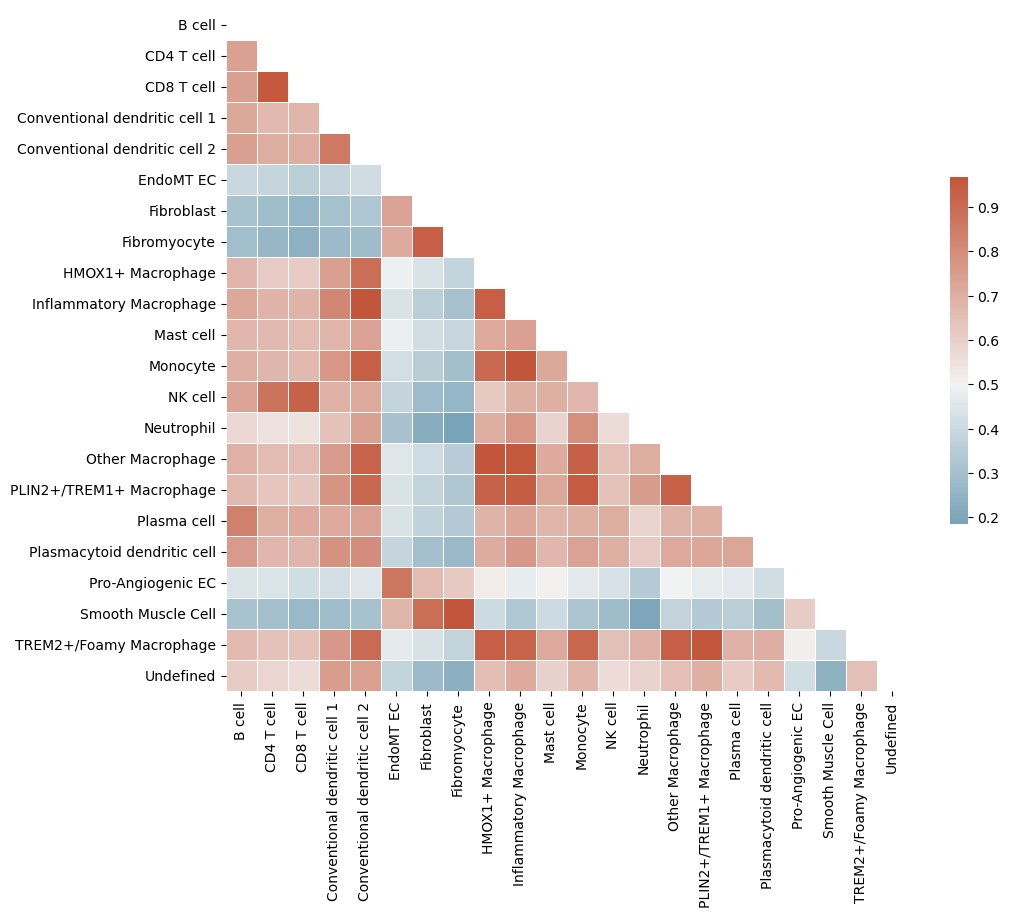

In [19]:
# Plot correlation of different cell types, using spearman rank method
corr = inf_aver.corr(method="spearman")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [20]:
# prepare anndata for cell2location model
c2l.models.Cell2location.setup_anndata(adata=adata_visium, batch_key="sample")

map_model2wo = c2l.models.Cell2location(
    adata_visium, cell_state_df=inf_aver,
    # the expected average cell abundance: tissue-dependent hyper-prior which can be estimated from paired histology:
    N_cells_per_location=5,
    # hyperparameter controlling normalisation of within-experiment variation in RNA detection:
    detection_alpha=200
)
map_model2wo.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'sample',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  12   │
│         n_cells          │ 16593 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   1   │
│          n_vars          │ 4756  │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                   batch State Registry                    
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['sample'] │  FW104302   │          0          │
│                     │  FW104306   │          1          │
│                     │  FW104860   │          2          │
│                     │ FW106005_v2 │          3          │
│                     │  FW106006   │          4          │
│                     │  FW106008   │          5          │
│                     │  FW106010   │          6          │
│                     │  FW106012   │          7          │
│                     │  FW106014   │          8          │
│                     │  FW106016   │          9          │
│                     │  FW106018   │         10          │
│                     │  FW106022   │         11          │
└─────────────────────┴─────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

In [21]:
# TODO Maxi: set up the different models and run them

In [22]:
# The training is completed in another notebook
map_model2wo = c2l.models.Cell2location.load(os.environ.get("PATH_TO_MAP_MODEL2WO"), adata_visium)
adata_visium = map_model2wo.export_posterior(adata_visium, sample_kwargs={'num_samples': 1000, 'batch_size': map_model2wo.adata.n_obs})

INFO     File /home/b/buit/map_model/model.pt already downloaded                                                   


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training:   0%|          | 0/30000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=1` reached.


Sampling local variables, batch:   0%|          | 0/1 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/999 [00:00<?, ?it/s]

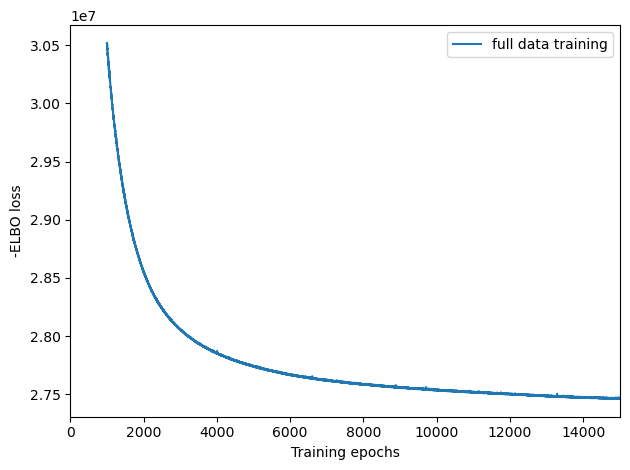

In [23]:
map_model2wo.plot_history(1000)
plt.legend(labels=['full data training']);

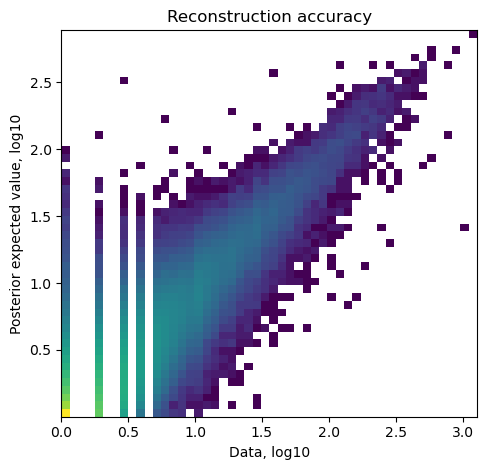

In [24]:
map_model2wo.plot_QC()

In [ ]:
map_model2wo.plot_spatial_QC_across_batches()

In [ ]:
adata_visium.obs[adata_visium.uns['mod']['factor_names']] = adata_visium.obsm['q05_cell_abundance_w_sf']

In [ ]:
adata_visium.obs

In [ ]:
sc.pl.spatial(select_slide(adata_visium,'FW106005_v2'), color=['Pro-Angiogenic EC','EndoMT EC'],vmin=0, cmap='magma', vmax=1.5)

In [ ]:
sc.pl.spatial(select_slide(adata_visium,'FW106022'), color=['Pro-Angiogenic EC','EndoMT EC'],vmin=0, cmap='magma', vmax=1.5)

In [ ]:
sc.pl.spatial(select_slide(adata_visium,'FW104302'), color=['Pro-Angiogenic EC','EndoMT EC'],vmin=0, cmap='magma', vmax=1.5)

### Downstream analysis

In [ ]:
# compute KNN using the cell2location output stored in adata.obsm
sc.pp.neighbors(adata_visium, use_rep='q05_cell_abundance_w_sf',
                n_neighbors = 15)

# Cluster spots into regions using scanpy
sc.tl.leiden(adata_visium, resolution=1.1, flavor="igraph", n_iterations=2, directed=False)

# add region as categorical variable
adata_visium.obs["region_cluster"] = adata_visium.obs["leiden"].astype("category")

In [ ]:
# compute UMAP using KNN graph based on the cell2location output
sc.tl.umap(adata_visium, min_dist = 0.3, spread = 1)

# show regions in UMAP coordinates
with mpl.rc_context({'axes.facecolor':  'white',
                     'figure.figsize': [8, 8]}):
    sc.pl.umap(adata_visium, color=['region_cluster'], size=30,
               color_map = 'RdPu', ncols = 2, legend_loc='on data',
               legend_fontsize=20)

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    for i, s in enumerate(sorted_samples):
        slide = select_slide(adata_visium, s)
        sc.pl.spatial(slide, color=['region_cluster', 'Pro-Angiogenic EC'],
                  size=1.3, img_key='hires', alpha=0.5)